# Setup and define custom dataset class

The custom dataset class finds each raw audio sample and corresponding label, encodes the label and returns the raw audio sample as mono-channel as well as the label.

In [21]:
import torch
import torchaudio

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data, label_encoder=None):
        # Initialize attributes
        self.data = data["uuid"]
        self.label = data["status"]
        self.label_encoder = label_encoder
        self.sample_rate = {}

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Extract audio sample from idx
        audio_path = self.data[idx]
        print("audio_path", audio_path)

        # Load in audio
        audio_sample, sample_rate = torchaudio.load(audio_path)
        self.sample_rate[idx] = sample_rate
        
        # Extract audio label from idx and transform
        audio_label = [self.label[idx]]
        audio_label = self.label_encoder.transform(audio_label)
        
        # Check if audio sample is stereo -> convert to mono
        if audio_sample.shape[0] > 1:
            audio_sample = audio_sample.mean(dim=0, keepdim=True)
            
        #return audio_sample, torch.tensor(audio_label, dtype=torch.int64)
        return audio_sample, sample_rate
            

    def __get_sample_rate__(self, idx):
        # If needed extract sample rate
        return self.sample_rate.get(idx)

# Custom collate function

The following collate function will take batches of raw audio samples and zero pad them to match the largest sized audio sample.

In [22]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.0)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    # A data tuple has the form:
    # waveform, label

    # Separate audio samples and labels
    waveforms, labels = zip(*batch)
    
    # Pad the audio samples
    #padded_waveforms = pad_sequence(waveforms)

    # Convert labels to tensor
    labels = torch.tensor(labels)

    #return waveforms, labels
    #return padded_waveforms, labels
    return waveforms, labels

# Miscellaneous functions

The following code block contains miscellaneous functions such as plotting of waveforms, spectograms, fbank, and preprocessing of the data.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import librosa 

# Stolen from pytorch tutorial xd
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = np.array(waveform)

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots()
    time_axis = np.linspace(0, len(waveform) / sr, num=len(waveform))
    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    if title:
        ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    plt.show()

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest",
    )

def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    
def preprocess_data(data_path, data_dir_path, output_dir):
    # Read data file then remove every column other than the specified columns
    # Removes empty samples and filters through cough probability
    data = pd.read_csv(data_path, sep=",")
    data = (
        data[["uuid", "cough_detected", "SNR", "age", "gender", "status"]]
        .loc[data["cough_detected"] >= 0.5]
        .dropna().reset_index(drop=True)
    )

    # Check if the following MP3 with uuid exists
    mp3_data = []
    non_exist = []
    for file in data["uuid"]:
        if os.path.exists(os.path.join(data_dir_path, f"{file}.mp3")):
            mp3_data.append(os.path.join(data_dir_path, f"{file}.mp3"))
        else:
            non_exist.append(file)
        # elif os.path.exists(os.path.join(data_dir_path, f'{file}.ogg')):
        #    ogg_data.append(os.path.join(data_dir_path, f'{file}.ogg'))

    # Remove entries with missing MP3 files from the original data
    data = data[~data["uuid"].isin(non_exist)]

    # Replace the uuids with the path to uuid
    data["uuid"] = mp3_data
    
    # Save the data as csv
    data.to_csv(os.path.join(output_dir, "audio_data.csv"), index=False)
    print("Finished processing!")

# Dataset specific functions

The following codeblock contains functions specially related to the dataset preprocessing.

In [24]:
from sklearn.model_selection import train_test_split

def preprocess_dataset(data, test_size):
    # Extract audio samples and labels
    X = data.drop(columns=["status"])
    y = data["status"]


    # Perform a stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Combine audio samples and target labels for training and validation sets
    train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

    return train_data, test_data

def weighted_sample(data):
    # Find class distribution
    class_counts = data["status"].value_counts()
    # print(class_counts)

    # Check class weights
    class_weights = 1 / class_counts
    # print(class_weights)

    # Adjust weighting to each sample
    sample_weights = [1 / class_counts[i] for i in data["status"].values]
    # print("len sample weights:",len(sample_weights))

    return sample_weights

def undersample(data, n, normalize=False):
    # Step 1: Identify majority class
    class_counts = data["status"].value_counts()
    majority_class = class_counts.idxmax()

    # Step 2: Calculate desired class distribution (e.g., balanced distribution)
    desired_class_count = n  # Target number of samples for each class

    # Step 3: Select subset from majority class
    undersampled_data_majority = data[data["status"] == majority_class].sample(
        n=desired_class_count
    )

    # Combine with samples from minority classes
    undersampled_data_minority = data[~(data["status"] == majority_class)]

    # Combine undersampled majority class with minority classes
    undersampled_data = pd.concat(
        [undersampled_data_majority, undersampled_data_minority]
    )

    # Shuffle the undersampled dataset
    undersampled_data = undersampled_data.sample(frac=1).reset_index(drop=True)

    return undersampled_data

def visualize_dataset(data, normalize, title):
    print(f"{title} Distribution")
    print(data["status"].value_counts(normalize=normalize))
    print("Total samples", len(data))

    plt.figure(figsize=(6, 4))
    plt.title(f"Histogram of Patient Status\n- {title}")
    plt.bar(data["status"].value_counts().index, data["status"].value_counts())
    plt.xticks(rotation=20, ha="right", fontsize=8)
    plt.xlabel("Class", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.show()

# Initialization of dataset and dataset loader

This codeblock includes the initialization of the dataset as well as any processing needed, such as splitting it into training/testing datasets, as well as different sampling techniques, such as undersampling/weighted sampling.

In [25]:
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Set seed for reproducibility
torch.manual_seed(42)

# Load data
data = pd.read_csv("misc_data/audio_data.csv")
#data['uuid'] = data['uuid'].apply(lambda x: x.replace('../Dataset/MP3/', "/kaggle/input/covid-19-audio-classification/MP3/"))

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform labels into encoded form
labels = ["healthy", "symptomatic", "COVID-19"]
encoded_labels = le.fit_transform(labels)

# Prepare standard dataset
train_data, test_data = preprocess_dataset(data, 0.3) # First split the original dataset into 70% training
val_data, test_data = preprocess_dataset(test_data, 0.5) # Second split the "test_data" into 50/50 validation and test (or technically 15/15)

# Prepare and create undersampled version
#undersampled_data = undersample(data, 2000, True)
#visualize_dataset(undersampled_data, None, "Standard")
#visualize_dataset(undersampled_data, "normalize", "Normalized")
#train_undersampled_data, test_undersampled_data = preprocess_dataset(undersampled_data, 0.3)
#val_undersampled_data, test_undersampled_data = preprocess_dataset(test_undersampled_data, 0.5)
#visualize_dataset(train_undersampled_data, None, "Train")
#visualize_dataset(train_undersampled_data, "normalize", "Train Normalized")
#visualize_dataset(val_undersampled_data, None, "Validation")
#visualize_dataset(val_undersampled_data, "normalize", "Validation Normalized")

# Prepare and create weighted sampler
#train_sample_weights = weighted_sample(train_data)
#val_sample_weights = weighted_sample(val_data)
#test_sample_weights = weighted_sample(test_data)

#train_weighted_Sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_data), replacement=True)
#val_weighted_Sampler = WeightedRandomSampler(weights=val_sample_weights, num_samples=len(val_data), replacement=True)
#test_weighted_Sampler = WeightedRandomSampler(weights=test_sample_weights, num_samples=len(test_data), replacement=True)

# Create AudioDataset instances for training and validation sets
# Standard dataset
train_dataset = AudioDataset(train_data, le)
val_dataset = AudioDataset(val_data, le)
test_dataset = AudioDataset(test_data, le)

# Undersampled dataset
#train_undersampled_dataset = AudioDataset(train_undersampled_data, le)
#test_undersampled_dataset = AudioDataset(test_undersampled_data, le)

# Create training and test dataloader instances
batch = 1
workers = 0
pin_memory = True

train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, num_workers=workers, collate_fn=collate_fn, pin_memory=pin_memory)
#val_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=workers, collate_fn=collate_fn, pin_memory=pin_memory)
#test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=workers, collate_fn=collate_fn, pin_memory=pin_memory)

"""
train_undersampled_dataloader = DataLoader(
    train_dataset,
    batch_size=batch,
    shuffle=True,
    num_workers=workers,
    collate_fn=collate_fn,
    pin_memory=True,
)
val_undersampled_dataloader = DataLoader(
    val_dataset,
    batch_size=batch,
    shuffle=False,
    num_workers=workers,
    collate_fn=collate_fn,
    pin_memory=True,
)
test_undersampled_dataloader = DataLoader(
    test_dataset,
    batch_size=batch,
    shuffle=False,
    num_workers=workers,
    collate_fn=collate_fn,
    pin_memory=True,
)
"""

#train_weighted_dataloader = DataLoader(train_dataset, sampler=train_weighted_Sampler, batch_size=batch, num_workers=workers, collate_fn=collate_fn, pin_memory=True)
#val_weighted_dataloader = DataLoader(val_dataset, sampler=val_weighted_Sampler, batch_size=batch, num_workers=workers, collate_fn=collate_fn, pin_memory=True)
#test_weighted_dataloader = DataLoader(test_dataset, sampler=test_weighted_Sampler, batch_size=batch, num_workers=workers, collate_fn=collate_fn, pin_memory=True)

'\ntrain_undersampled_dataloader = DataLoader(\n    train_dataset,\n    batch_size=batch,\n    shuffle=True,\n    num_workers=workers,\n    collate_fn=collate_fn,\n    pin_memory=True,\n)\nval_undersampled_dataloader = DataLoader(\n    val_dataset,\n    batch_size=batch,\n    shuffle=False,\n    num_workers=workers,\n    collate_fn=collate_fn,\n    pin_memory=True,\n)\ntest_undersampled_dataloader = DataLoader(\n    test_dataset,\n    batch_size=batch,\n    shuffle=False,\n    num_workers=workers,\n    collate_fn=collate_fn,\n    pin_memory=True,\n)\n'

# Initialize and define MFCC feature extractor

In the following codeblock the MFCC specific parameters are defined and initialized. The codeblock also includes a function that pads the extracted MFCC features in order to pass it to the model.

In [26]:
from torchaudio.transforms import MFCC
from torchvision.transforms import Resize
import torch.nn.functional as F

def MFCC_Features(data, Normalize=False, resize=False):
    # Extract MFCC features
    features = mfcc(data)
    
    # Hardcoded padding
    features = F.pad(features, (0,6000 - features.shape[3]), "constant", 0)
    
    
    # Normalize the features
    if Normalize == True:
        features = (features - features.mean()) / features.std()
    
    # Add two artificial channels filled with zeros
    if resize == True:
        #artificial_channels = torch.zeros(features.shape[0], 2, features.shape[2], features.shape[3])
        #features = torch.cat([features, artificial_channels], dim=1)
        features = Resize((224,224), antialias=True)(features)
    
    return features

# Settings for MelSpectrogram computation
melkwargs = {
    "n_mels": 80,  # How many mel frequency filters are used
    "n_fft": 480,  # How many fft components are used for each feature
    "win_length": 480,  # How many frames are included in each window
    "hop_length": 160,  # How many frames the window is shifted for each component
    "center": False,  # Whether frams are padded such that the component of timestep t is centered at t
    "f_max": 10000,  # Maximum frequency to consider
    "f_min": 0,
}

# Instantiate MFCC feature extractor
mfcc = MFCC(
    n_mfcc=22,  # Number of cepstrum components
    sample_rate=22000,  # Sample rate of input audio
    melkwargs=melkwargs)  # Keyword arguments for MelSpectogram

# Testing stuff

In [41]:
def waveform_plot(signal, sr, title):
    # Calculate time axis
    time = np.arange(0, len(signal)) / sr
    
    # Calculate dBFS values
    #db_signal = 20 * np.log10(np.abs(signal) / 1)
    
    if signal.any() != 0:
        db_signal = 20 * np.log10(np.abs(signal) / 1)
    else:
        db_signal = -60
    
    
    # Calculate dBFS values with handling division by zero
    #db_signal = 20 * np.log10((np.abs(signal) + np.finfo(float).eps) / 1)

    plt.figure(figsize=(10, 8))
    
    # Plot standard waveform
    plt.subplot(3,1,1) 
    plt.plot(time, signal, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    
    plt.subplot(3,1,2)
    # Plot waveform in dB scale
    plt.plot(time, db_signal, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (dBFS)')
    plt.title(title)
    plt.grid(True)
    
    n_fft = 2048  # Length of the FFT window
    hop_length = 512  # Hop length for FFT
    S = np.abs(librosa.stft(signal.astype(float), n_fft=n_fft, hop_length=hop_length))

    # Convert amplitude to dB scale (sound pressure level)
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    # Get frequency bins corresponding to FFT
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Step 3: Plot the SPL values over frequency
    plt.subplot(3,1,3)
    plt.plot(freqs, np.mean(S_db, axis=1), color='b')
    plt.title('Sound Pressure Level (SPL) vs. Frequency')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('SPL (dB)')
    plt.grid(True)
    plt.xlim([20, 25000])  # Set frequency range for better visualization
    #plt.xscale('log')  # Use log scale for frequency axis
    
    
    plt.tight_layout()
    plt.show()

audio_path ../Dataset/MP3/46064dba-fcc4-42a0-8eb2-89785d549f44.mp3


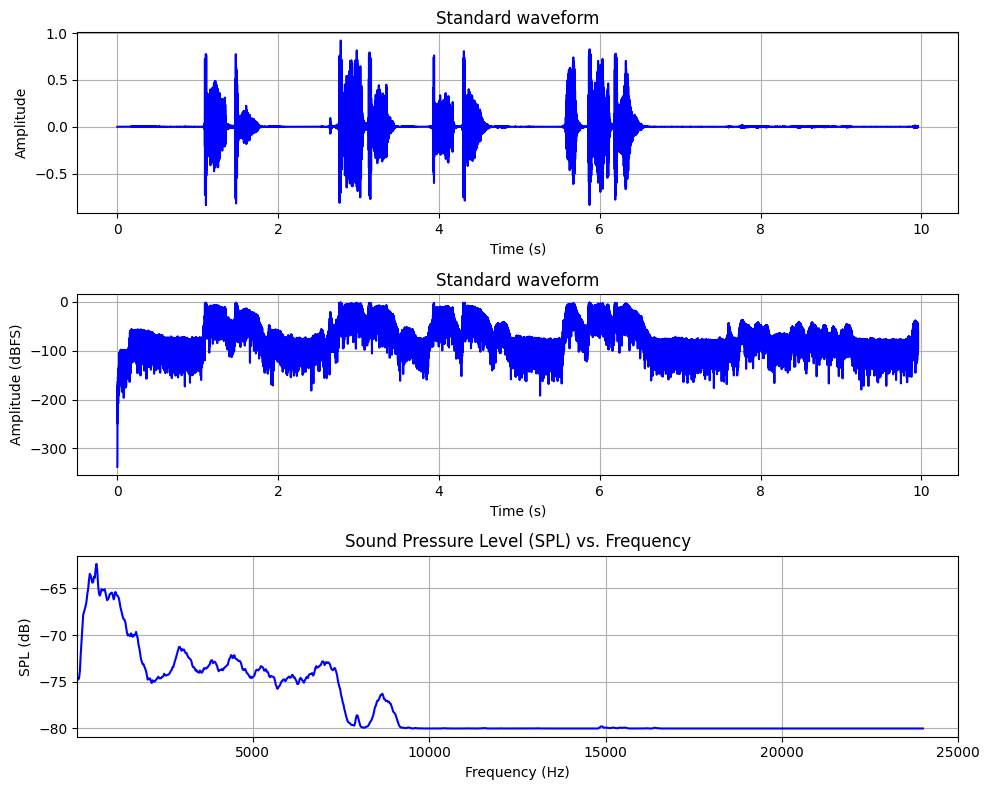

TypeError: type numpy.ndarray doesn't define __round__ method

In [62]:
from pydub.silence import split_on_silence
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pydub import AudioSegment
import torch.optim as optim
import torchaudio
import librosa
import torch
import os
import numpy as np

inputs, labels = next(iter(train_dataloader))
#print(inputs := np.array(inputs))
#print(labels := np.array(labels))
#print(inputs[0][0])
#print(labels[0])

signal = np.array(inputs[0][0])
sr = np.array(labels[0])

waveform_plot(signal, sr, "Standard waveform")

#y, srr = librosa.load("../Dataset/MP3/46064dba-fcc4-42a0-8eb2-89785d549f44.mp3", sr=None)
#plot_dB(y, srr)


print()

# make the audio in pydub audio segment format
aud = AudioSegment(signal.tobytes(),frame_rate = sr,
                     sample_width = signal.dtype.itemsize, channels = 1)

# use split on sience method to split the audio based on the silence, 
# here we can pass the min_silence_len as silent length threshold in ms and intensity thershold
audio_chunks = split_on_silence(
    aud,
    min_silence_len = 1,
    silence_thresh = -60,
    keep_silence = 50)

#audio chunks are combined here
audio_processed = sum(audio_chunks)
#audio_processed.export("processed_audio.mp3", format="mp3", parameters=["-ar", str(sr)])

from pydub.playback import play
#play(audio_processed)
audio_processed = np.array(audio_processed.get_array_of_samples())

output = AudioSegment(audio_processed.tobytes(), frame_rate=sr, sample_width = signal.dtype.itemsize, channels = 1)
output.export(out_f="TEST.mp3", format="mp3")
waveform_plot(audio_processed, sr, "Silence removed")

"""
# Define parameters for silence detection
# Adjust these parameters based on your audio
min_silence_len = 100  # Minimum length of silence in milliseconds
silence_thresh = -60  # Silence threshold in dBFS

# Convert NumPy array to AudioSegment
audio_segment = AudioSegment(signal.tobytes(), frame_rate=sr, sample_width=2, channels=1)

# Split the audio based on silence
chunks = split_on_silence(audio_segment, min_silence_len=min_silence_len, silence_thresh=silence_thresh)

# Concatenate non-silent chunks
output_signal = sum(chunks)
output_signal = np.array(output_signal.get_array_of_samples())




#features = MFCC_Features(inputs, Normalize=True, resize=False)
#plot_spectrogram(features[0][0], title="Normalized")
#features = MFCC_Features(inputs, Normalize=True, resize=True)
#plot_spectrogram(features[0][0], title="Normalized Resized")
"""

KeyboardInterrupt: 

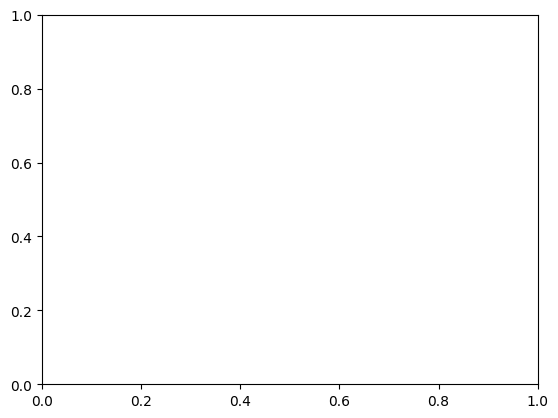

In [ ]:
plt.subplots(1, 1)
plt.plot(inputs[0].numpy())
plt.title("Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
timemr[e00000]

# Initializing and defining model

The following codeblock contains the initialization of the ResNet50 model from the PyTorch library.

In [ ]:
from torchvision import models
import torch.nn as nn

# Load in the pre-trained resnet model
model = models.vgg16_bn(weights=None, num_classes=3)
#model = models.resnet18(weights=None, num_classes=3)
#model = models.resnet50()

# Modifying the first layer to be able to pass 1-channel image (spectrogram) for ResNet model
#num_features = model.fc.in_features
#model.fc = nn.Linear(num_features, 3)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1,1), padding=(1, 1))

# Set the model to training mode and put it on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device running on: {device}")

# Wrap your model with DataParallel
model = nn.DataParallel(model)
model.to(device); # add ";" to keep from printing the network architecture

# Setup weights and bias logging

In [ ]:
import wandb

# Initialize wandb
!wandb login --relogin 9be53a0c7076cae09612be80ee5e0e80d9dac79c

# Defining training variables
lr = 0.001
step = 5
decay = 0.1
optim = "adam"
gamma = 0.5
epochs = 50

# Defining weights and biases config
wandb.init(
    # set the wandb project where this run will be logged
    project="mini-project",
    config={
    "architecture": "VGG-16 Batch Normalization",
    "dataset": "COVID-19 Audio Classification",
    "learning_rate": lr,
    "step_size": step,
    "weight_decay": decay,
    "optimizer": optim,
    "gamma": gamma,
    "epochs": epochs
    }
)

# Training loop

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torch
import os

if optim == "adam":
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
else: 
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=decay)
scheduler = StepLR(optimizer, step_size=step, gamma=0.5)
criterion = nn.CrossEntropyLoss()
#scaler = GradScaler()
log_interval = 20
best_vloss = float("inf")
model_no = 0

print("Currently: Training")
for epoch in range(epochs):
    model.train() # Initiate training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Training loop
    for i, (inputs, targets) in tqdm(enumerate(
       train_weighted_dataloader),
       total=len(train_weighted_dataloader),
       leave=True,
       desc=f"Epoch {epoch+1}/{epochs} | Training"
        ):
        #print(f"========== BATCH {i} ========== ")
        #for idx, f in enumerate(features):
        #    print(f"{idx+1} | {f.shape}")
        #print(f"========== BATCH {i} ========== ")
        
        features = MFCC_Features(inputs) # Compute the MFCC features
        features, targets = features.to(device), targets.to(device) # Load them onto GPU
        optimizer.zero_grad() # Zero the parameters
        outputs = model(features) # Retrieve the output from the model
        loss = criterion(outputs, targets) # Compute the loss
        #loss = F.cross_entropy(outputs, targets, reduction='mean')
        loss.backward() # Compute gradients of the loss
        optimizer.step() # Update weights
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)
        
        if i % log_interval == 0:
            print(f"Epoch {epoch+1}/{epochs} | Batch {i}/{len(train_weighted_dataloader)} | Training Loss: {loss.item():.4f}")
    
    # Compute accuracy
    accuracy = correct_predictions / total_predictions
    
    print(f"Training Accuracy: {accuracy:.4f}")
    
    # Compute average training loss for the epoch
    avg_loss = running_loss / len(train_weighted_dataloader)
        
    # Validation loop
    running_vloss = 0.0
    vcorrect_predictions = 0
    vtotal_predictions = 0
    model.eval()
    with torch.no_grad(): # Disable gradient computation
        for j, (vinputs, vtargets) in tqdm(enumerate(
            val_weighted_dataloader),
            total=len(val_weighted_dataloader),
            leave=True,
            desc=f"Epoch {epoch+1}/{epochs} | Validating"):
            vfeatures = MFCC_Features(vinputs) # Compute the MFCC features
            vfeatures, vtargets = vfeatures.to(device), vtargets.to(device) # Load them onto GPU
            voutputs = model(vfeatures)
            vloss = criterion(voutputs, vtargets)
            #vloss = F.cross_entropy(voutputs, vtargets, reduction='mean')
            running_vloss += vloss.item()
            
            # Calculate accuracy
            _, vpredicted = torch.max(voutputs, 1)
            vcorrect_predictions += (vpredicted == vtargets).sum().item()
            vtotal_predictions += vtargets.size(0)
    
    # Compute average validation loss for the epoch
    avg_vloss = running_vloss / len(val_weighted_dataloader)
    
    # Compute accuracy
    vaccuracy = vcorrect_predictions / vtotal_predictions
    
    # Compute precision, recall, F1 score
    precision = precision_score(vtargets.cpu(), vpredicted.cpu(), average='macro',zero_division=0.0)
    recall = recall_score(vtargets.cpu(), vpredicted.cpu(), average='macro',zero_division=0.0)
    f1 = f1_score(vtargets.cpu(), vpredicted.cpu(), average='macro',zero_division=0.0)
    
    # Log metrics to wandb
    wandb.log({"precision": precision, "recall": recall, "f1_score": f1})
    wandb.log({"epoch": epoch+1, "train_loss": avg_loss,"train_acc": accuracy, "val_loss": avg_vloss, "val_accuracy": vaccuracy})
    
    print(f"Epoch #{epoch+1} | Training Loss: {avg_loss:.4f} | Validation Loss: {avg_vloss:.4f} | Validation Accuracy: {vaccuracy:.4f}\n           Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
                      
    # Update learning rate
    #print_lr(is_verbose, group, lr, epoch=None)
    scheduler.step()
    
    print(f"Epoch {epoch+1}, Learning Rate: {scheduler.get_last_lr()}")
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_no += 1
        if not os.path.exists("/kaggle/working/models"):
            os.makedirs('models')
        model_path = f"/kaggle/working/models/VGG16_bn_weighted_model_no_{model_no}_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_path)

# Finish the run
wandb.finish()